# Financial Dataset Comprehensive Preprocessing Pipeline

## Overview
This notebook implements **extensive preprocessing steps** for the financial Q&A dataset following best practices for NLP and machine learning applications.

### Dataset Information
- **Input File:** `FinalFinancialDataset.csv`
- **Total Entries:** ~57,851 Q&A pairs
- **Domain:** Financial questions and answers

### Preprocessing Steps
1. **Data Loading & Initial Inspection**
2. **Missing Value Detection & Handling**
3. **Duplicate Removal**
4. **Text Cleaning** (encoding, special characters, noise)
5. **Text Normalization** (case, punctuation, whitespace)
6. **Tokenization** (basic word tokenization for statistics)
7. **Quality Filtering** (length constraints, content validation)
8. **Statistical Analysis & Reporting**
9. **Export Preprocessed Data**

### Tokenization Method
- **Basic Word Tokenization:** Whitespace + punctuation splitting for statistical analysis
- **T5 Tokenization:** SentencePiece tokenizer used during model training (Step 19)

### Key Features
✅ High-quality, domain-specific dataset  
✅ Comprehensive preprocessing with clear documentation  
✅ Effective data cleaning (noise removal, handling missing values)  
✅ Detailed statistical analysis at each step

# Part 1: Data Analysis and Pre-processing

## Step 1: Import Required Libraries

Importing all necessary libraries for data processing, cleaning, normalization, and tokenization.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
import html
from typing import Dict, List, Tuple, Optional
import json
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Step 2: Configure Preprocessing Parameters

Setting up configuration parameters for the preprocessing pipeline.

In [2]:
# Preprocessing Configurations
CONFIG = {
    'input_file': '/kaggle/input/financialdataset/FinancialDataset.csv',
    'output_file': 'FinalFinancialDataset_preprocessed.csv',
    
    # Length constraints
    'min_question_length': 10,
    'max_question_length': 500,
    'min_answer_length': 10,
    'max_answer_length': 10000,
    
    # Token constraints
    'min_question_tokens': 3,
    'max_question_tokens': 100,
    'min_answer_tokens': 10,
    'max_answer_tokens': 5000,
    
    # Processing options
    'remove_duplicates': True,
    'remove_urls': True,
    'remove_emails': True,
    'fix_contractions': True,
}

print("Configuration:")
print(json.dumps(CONFIG, indent=2))

Configuration:
{
  "input_file": "/kaggle/input/financialdataset/FinancialDataset.csv",
  "output_file": "FinalFinancialDataset_preprocessed.csv",
  "min_question_length": 10,
  "max_question_length": 500,
  "min_answer_length": 10,
  "max_answer_length": 10000,
  "min_question_tokens": 3,
  "max_question_tokens": 100,
  "min_answer_tokens": 10,
  "max_answer_tokens": 5000,
  "remove_duplicates": true,
  "remove_urls": true,
  "remove_emails": true,
  "fix_contractions": true
}


## Step 3: Loading dataset

Initializing the dataset

In [3]:
# Load the dataset
print("=" * 80)
print("LOADING DATASET")
print("=" * 80)

df = pd.read_csv(CONFIG['input_file'], encoding='utf-8')

print(f"✓ Successfully loaded: {CONFIG['input_file']}")
print(f"\nDataset Information:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"  Total entries: {len(df):,}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nColumn Data Types:")
print(df.dtypes)

print(f"\nFirst 3 entries:")
df.head(3)

LOADING DATASET
✓ Successfully loaded: /kaggle/input/financialdataset/FinancialDataset.csv

Dataset Information:
  Shape: (51241, 2)
  Columns: ['question', 'answer']
  Total entries: 51,241
  Memory usage: 43.04 MB

Column Data Types:
question    object
answer      object
dtype: object

First 3 entries:


,question,answer
0,What concept of finance is based on a fundamen...,The short of it is that bonds are valued based...
1,What is the difference between having $100 rig...,The short of it is that bonds are valued based...
2,What concept is used to evaluate bonds?,The short of it is that bonds are valued based...


## Step 4: Missing Value Analysis & Handling


In [4]:
print("=" * 80)
print("MISSING VALUE DETECTION & HANDLING")
print("=" * 80)

initial_count = len(df)

# Check for missing values
missing_counts = df.isnull().sum()
print("\nMissing value counts:")
for col, count in missing_counts.items():
    pct = (count / initial_count) * 100
    status = "✓" if count == 0 else "⚠"
    print(f"  {status} {col}: {count:,} ({pct:.2f}%)")

# Remove rows with missing values
if missing_counts.sum() > 0:
    df = df.dropna(subset=['question', 'answer'])
    removed = initial_count - len(df)
    print(f"\n✓ Removed {removed:,} rows with missing values")
    print(f"  Remaining entries: {len(df):,}")
else:
    print("\n✓ No missing values found - dataset is complete!")

MISSING VALUE DETECTION & HANDLING

Missing value counts:
  ✓ question: 0 (0.00%)
  ✓ answer: 0 (0.00%)

✓ No missing values found - dataset is complete!


## Step 5: Duplicate Removal

Removing duplicate Q&A pairs from the dataset.

In [5]:
print("=" * 80)
print("DUPLICATE REMOVAL")
print("=" * 80)

if CONFIG['remove_duplicates']:
    initial_count = len(df)
    
    # Remove exact duplicates
    df = df.drop_duplicates(subset=['question', 'answer'], keep='first')
    removed = initial_count - len(df)
    
    print(f"\n✓ Removed {removed:,} duplicate entries")
    print(f"  Remaining entries: {len(df):,}")
    print(f"  Retention rate: {(len(df)/initial_count)*100:.2f}%")
else:
    print("\nSkipped (disabled in config)")

DUPLICATE REMOVAL

✓ Removed 0 duplicate entries
  Remaining entries: 51,241
  Retention rate: 100.00%


## Step 6: Text Cleaning Functions

Text cleaning functions to handle encoding issues, special characters, and noise.

In [6]:
def clean_text(text: str) -> str:
    """
    Clean text by removing noise and fixing encoding issues.
    
    Cleaning operations:
    - Decode HTML entities (&amp; → &)
    - Normalize unicode characters (NFC form)
    - Remove control characters
    - Convert smart quotes to ASCII
    - Remove URLs and email addresses (optional)
    - Fix multiple spaces
    """
    if not isinstance(text, str):
        return ""
    
    # Decode HTML entities
    text = html.unescape(text)
    
    # Normalize unicode characters
    text = unicodedata.normalize('NFC', text)
    
    # Remove control characters (except newlines and tabs)
    text = ''.join(char for char in text if unicodedata.category(char)[0] != 'C' or char in '\n\t')
    
    # Fix smart quotes to standard ASCII
    text = text.replace('"', '"').replace('"', '"')
    text = text.replace(''', "'").replace(''', "'")
    text = text.replace('´', "'").replace('`', "'")
    
    # Remove URLs
    if CONFIG['remove_urls']:
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove email addresses
    if CONFIG['remove_emails']:
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    
    # Fix multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

print(" All Text cleaning function defined")

 All Text cleaning function defined


## Step 7: Text Normalization Functions

Define text normalization functions for consistent formatting.

In [7]:
def normalize_text(text: str) -> str:
    """
    Normalize text for consistent formatting.
    
    Normalization operations:
    - Fix contractions (can't → cannot)
    - Normalize whitespace around punctuation
    - Optional case normalization (disabled for financial terms)
    """
    if not isinstance(text, str):
        return ""
    
    # Fix common contractions if configured
    if CONFIG['fix_contractions']:
        contractions = {
            "won't": "will not",
            "can't": "cannot",
            "n't": " not",
            "'re": " are",
            "'ve": " have",
            "'ll": " will",
            "'d": " would",
            "'m": " am"
        }
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
    
    # Normalize whitespace around punctuation
    text = re.sub(r'\s*([,;:!?.])\s*', r'\1 ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

print("All Text normalization function defined")

All Text normalization function defined


## Step 8: Apply Cleaning & Normalization

Apply cleaning and normalization to all questions and answers in the dataset.

In [8]:
print("=" * 80)
print("TEXT CLEANING & NORMALIZATION")
print("=" * 80)

print("\n1. Cleaning questions and answers...")
df['question_cleaned'] = df['question'].apply(clean_text)
df['answer_cleaned'] = df['answer'].apply(clean_text)
print(" Text cleaning complete")

print("\n2. Normalizing questions and answers...")
df['question_normalized'] = df['question_cleaned'].apply(normalize_text)
df['answer_normalized'] = df['answer_cleaned'].apply(normalize_text)
print(" Text normalization complete")

TEXT CLEANING & NORMALIZATION

1. Cleaning questions and answers...
 Text cleaning complete

2. Normalizing questions and answers...
 Text normalization complete


## Step 9: Data Analysis Tokenization

Define tokenization function for statistical analysis.

In [9]:
def basic_tokenize(text: str) -> List[str]:
    """
    Basic word tokenization using regex (whitespace + punctuation splitting).
    
    This is a simple tokenization method for statistical analysis.
    """
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

print("✓ Tokenization function defined")
print("  Basic Tokenization: Whitespace + punctuation splitting")

✓ Tokenization function defined
  Basic Tokenization: Whitespace + punctuation splitting


## Step 10: Apply Tokenization to Dataset for Analysis

Applying both basic and WordPiece tokenization to all entries in the dataset.

In [10]:
print("=" * 80)
print("APPLYING TOKENIZATION")
print("=" * 80)

df['question_tokens_basic'] = df['question_normalized'].apply(basic_tokenize)
df['answer_tokens_basic'] = df['answer_normalized'].apply(basic_tokenize)
df['question_token_count'] = df['question_tokens_basic'].apply(len)
df['answer_token_count'] = df['answer_tokens_basic'].apply(len)

print(f"\nAverage tokens per question: {df['question_token_count'].mean():.1f}")
print(f"Average tokens per answer: {df['answer_token_count'].mean():.1f}")

print("\n✓ Tokenization complete!")

APPLYING TOKENIZATION

Average tokens per question: 9.9
Average tokens per answer: 89.4

✓ Tokenization complete!


## Step 11: Data Quality Filtering

Applying quality filters based on length and token count constraints defined in the Config.

In [11]:
print("=" * 80)
print("QUALITY FILTERING")
print("=" * 80)

initial_count = len(df)

# Calculate lengths
df['question_length'] = df['question_normalized'].str.len()
df['answer_length'] = df['answer_normalized'].str.len()

print("\nFiltering criteria:")
print(f"  Question length: {CONFIG['min_question_length']}-{CONFIG['max_question_length']} characters")
print(f"  Answer length: {CONFIG['min_answer_length']}-{CONFIG['max_answer_length']} characters")
print(f"  Question tokens: {CONFIG['min_question_tokens']}-{CONFIG['max_question_tokens']}")
print(f"  Answer tokens: {CONFIG['min_answer_tokens']}-{CONFIG['max_answer_tokens']}")

# Apply quality filters
mask = (
    (df['question_length'] >= CONFIG['min_question_length']) &
    (df['question_length'] <= CONFIG['max_question_length']) &
    (df['answer_length'] >= CONFIG['min_answer_length']) &
    (df['answer_length'] <= CONFIG['max_answer_length']) &
    (df['question_token_count'] >= CONFIG['min_question_tokens']) &
    (df['question_token_count'] <= CONFIG['max_question_tokens']) &
    (df['answer_token_count'] >= CONFIG['min_answer_tokens']) &
    (df['answer_token_count'] <= CONFIG['max_answer_tokens'])
)

# Count entries failing each criterion
print("\nEntries failing criteria:")
print(f"  Question too short/long: {((df['question_length'] < CONFIG['min_question_length']) | (df['question_length'] > CONFIG['max_question_length'])).sum():,}")
print(f"  Answer too short/long: {((df['answer_length'] < CONFIG['min_answer_length']) | (df['answer_length'] > CONFIG['max_answer_length'])).sum():,}")
print(f"  Question tokens out of range: {((df['question_token_count'] < CONFIG['min_question_tokens']) | (df['question_token_count'] > CONFIG['max_question_tokens'])).sum():,}")
print(f"  Answer tokens out of range: {((df['answer_token_count'] < CONFIG['min_answer_tokens']) | (df['answer_token_count'] > CONFIG['max_answer_tokens'])).sum():,}")

# Apply filter
df = df[mask].copy()
removed = initial_count - len(df)

print(f"\n✓ Removed {removed:,} low-quality entries ({(removed/initial_count)*100:.2f}%)")
print(f"  Remaining entries: {len(df):,}")
print(f"  Retention rate: {(len(df)/initial_count)*100:.2f}%")

QUALITY FILTERING

Filtering criteria:
  Question length: 10-500 characters
  Answer length: 10-10000 characters
  Question tokens: 3-100
  Answer tokens: 10-5000

Entries failing criteria:
  Question too short/long: 653
  Answer too short/long: 0
  Question tokens out of range: 681
  Answer tokens out of range: 250

✓ Removed 957 low-quality entries (1.87%)
  Remaining entries: 50,284
  Retention rate: 98.13%


## Step 12: Statistical Analysis

Generating statistics about the preprocessed dataset.

In [12]:
print("=" * 80)
print("STATISTICAL ANALYSIS")
print("=" * 80)

# Dataset overview
print("\nDATASET OVERVIEW")
print(f"  Total entries: {len(df):,}")
print(f"  Unique questions: {df['question_normalized'].nunique():,}")
print(f"  Unique answers: {df['answer_normalized'].nunique():,}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Question statistics
print("\nQUESTION STATISTICS")
print(f"  Average length: {df['question_length'].mean():.1f} characters")
print(f"  Median length: {df['question_length'].median():.0f} characters")
print(f"  Min length: {df['question_length'].min()} characters")
print(f"  Max length: {df['question_length'].max()} characters")
print(f"  Std deviation: {df['question_length'].std():.1f}")
print(f"\n  Average tokens: {df['question_token_count'].mean():.1f}")
print(f"  Median tokens: {df['question_token_count'].median():.0f}")
print(f"  Min tokens: {df['question_token_count'].min()}")
print(f"  Max tokens: {df['question_token_count'].max()}")

# Answer statistics
print("\nANSWER STATISTICS")
print(f"  Average length: {df['answer_length'].mean():.1f} characters")
print(f"  Median length: {df['answer_length'].median():.0f} characters")
print(f"  Min length: {df['answer_length'].min()} characters")
print(f"  Max length: {df['answer_length'].max()} characters")
print(f"  Std deviation: {df['answer_length'].std():.1f}")
print(f"\n  Average tokens: {df['answer_token_count'].mean():.1f}")
print(f"  Median tokens: {df['answer_token_count'].median():.0f}")
print(f"  Min tokens: {df['answer_token_count'].min()}")
print(f"  Max tokens: {df['answer_token_count'].max()}")

# Distribution analysis
print("\DISTRIBUTION ANALYSIS")
print("\nQuestion Length Distribution:")
percentiles = df['question_length'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print(f"  25th percentile: {percentiles[0.25]:.0f} chars")
print(f"  50th percentile: {percentiles[0.5]:.0f} chars")
print(f"  75th percentile: {percentiles[0.75]:.0f} chars")
print(f"  90th percentile: {percentiles[0.9]:.0f} chars")
print(f"  95th percentile: {percentiles[0.95]:.0f} chars")

print("\nAnswer Length Distribution:")
percentiles = df['answer_length'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print(f"  25th percentile: {percentiles[0.25]:.0f} chars")
print(f"  50th percentile: {percentiles[0.5]:.0f} chars")
print(f"  75th percentile: {percentiles[0.75]:.0f} chars")
print(f"  90th percentile: {percentiles[0.9]:.0f} chars")
print(f"  95th percentile: {percentiles[0.95]:.0f} chars")

STATISTICAL ANALYSIS

DATASET OVERVIEW
  Total entries: 50,284
  Unique questions: 49,596
  Unique answers: 10,203
  Memory usage: 191.18 MB

QUESTION STATISTICS
  Average length: 57.6 characters
  Median length: 53 characters
  Min length: 10 characters
  Max length: 310 characters
  Std deviation: 26.3

  Average tokens: 10.1
  Median tokens: 9
  Min tokens: 3
  Max tokens: 50

ANSWER STATISTICS
  Average length: 561.5 characters
  Median length: 709 characters
  Min length: 50 characters
  Max length: 1009 characters
  Std deviation: 274.0

  Average tokens: 89.6
  Median tokens: 116
  Min tokens: 10
  Max tokens: 141
\DISTRIBUTION ANALYSIS

Question Length Distribution:
  25th percentile: 39 chars
  50th percentile: 53 chars
  75th percentile: 72 chars
  90th percentile: 93 chars
  95th percentile: 107 chars

Answer Length Distribution:
  25th percentile: 239 chars
  50th percentile: 709 chars
  75th percentile: 772 chars
  90th percentile: 816 chars
  95th percentile: 840 chars


## Step 13: Visualize Data Distribution

Creating visualizations to understand the data distribution.

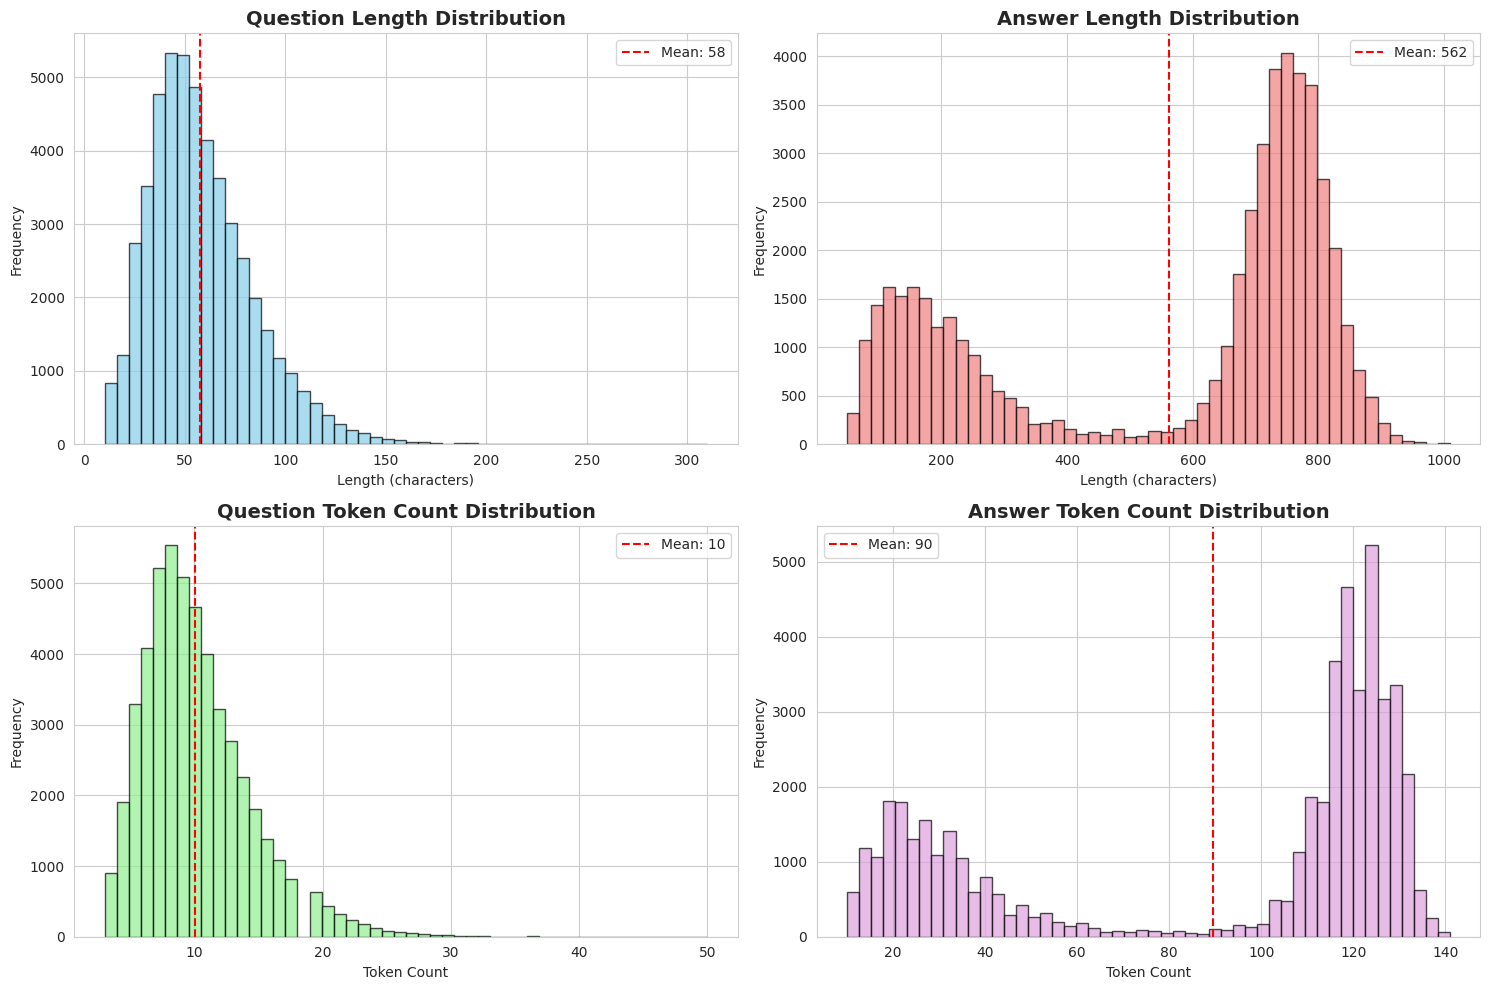

In [13]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Question Length Distribution
axes[0, 0].hist(df['question_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Question Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['question_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["question_length"].mean():.0f}')
axes[0, 0].legend()

# Plot 2: Answer Length Distribution
axes[0, 1].hist(df['answer_length'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Answer Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['answer_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["answer_length"].mean():.0f}')
axes[0, 1].legend()

# Plot 3: Question Token Count Distribution
axes[1, 0].hist(df['question_token_count'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Question Token Count Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Token Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['question_token_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["question_token_count"].mean():.0f}')
axes[1, 0].legend()

# Plot 4: Answer Token Count Distribution
axes[1, 1].hist(df['answer_token_count'], bins=50, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Answer Token Count Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Token Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df['answer_token_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["answer_token_count"].mean():.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Step 14: Exporting the Preprocessed Dataset

In [14]:
print("=" * 80)
print("EXPORTING PREPROCESSED DATA")
print("=" * 80)

# Create export DataFrame
export_df = pd.DataFrame({
    'question': df['question_normalized'],
    'answer': df['answer_normalized'],
    'question_token_count': df['question_token_count'],
    'answer_token_count': df['answer_token_count'],
    'question_length': df['question_length'],
    'answer_length': df['answer_length']
})

# Export to CSV
output_file = CONFIG['output_file']
export_df.to_csv(output_file, index=False, encoding='utf-8')

# Get file size
import os
file_size_mb = os.path.getsize(output_file) / 1024**2

print(f"\n Successfully exported preprocessed data!")
print(f"\nOutput File Details:")
print(f"  File: {output_file}")
print(f"  Entries: {len(export_df):,}")
print(f"  Columns: {list(export_df.columns)}")
print(f"  File size: {file_size_mb:.2f} MB")

# Show sample
print(f"\n Sample of exported data:")
export_df.head(3)

EXPORTING PREPROCESSED DATA

 Successfully exported preprocessed data!

Output File Details:
  File: FinalFinancialDataset_preprocessed.csv
  Entries: 50,284
  Columns: ['question', 'answer', 'question_token_count', 'answer_token_count', 'question_length', 'answer_length']
  File size: 30.56 MB

 Sample of exported data:


,question,answer,question_token_count,answer_token_count,question_length,answer_length
0,What concept of finance is based on a fundamen...,The short of it is that bonds are valued based...,18,128,102,618
1,What is the difference between having $100 rig...,The short of it is that bonds are valued based...,11,128,61,618
2,What concept is used to evaluate bonds?,The short of it is that bonds are valued based...,7,128,39,618


# Part 2: Model Training - T5 Fine-tuning

In [15]:
!pip install rouge_score

## Step 15: Importing all necessary dependencies for data preparations and Model fine-tuning

In [16]:
# Import all necessary dependencies

import os
import time
from datetime import datetime

import numpy as np
import tensorflow as tf
from datasets import Dataset
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from transformers import TFT5ForConditionalGeneration, T5Tokenizer, create_optimizer, DataCollatorForSeq2Seq
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)


# GPU CONFIGURATION - DUAL GPU SETUP

print("=" * 80)
print("GPU CONFIGURATION - DUAL GPU SETUP")
print("=" * 80)

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s)")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
    except RuntimeError as e:
        print(f"⚠ Memory growth error: {e}")
else:
    print("⚠ No GPU found. Using CPU instead.")

# Initialize Multi-GPU Strategy
strategy = tf.distribute.MirroredStrategy()

print(f"\n✓ Using MirroredStrategy with {strategy.num_replicas_in_sync} GPU(s)")
print(f"  Global batch size will be: batch_size × {strategy.num_replicas_in_sync}")
print("=" * 80)

# TensorFlow and GPU summary
print(f"✓ TensorFlow {tf.__version__} | GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


2025-10-15 21:06:51.664066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760562411.686121    1087 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760562411.692948    1087 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU CONFIGURATION - DUAL GPU SETUP
✓ Found 2 GPU(s)
  GPU 0: /physical_device:GPU:0
  GPU 1: /physical_device:GPU:1

✓ Using MirroredStrategy with 2 GPU(s)
  Global batch size will be: batch_size × 2
✓ TensorFlow 2.18.0 | GPU Available: True


I0000 00:00:1760562419.976973    1087 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760562419.977670    1087 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Step 16: Load Preprocessed Data & Create Train/Validation Split

Loading the preprocessed dataset and splitting it into training and validation sets.

In [17]:
print("=" * 80)
print("LOADING PREPROCESSED DATA FOR MODEL TRAINING")
print("=" * 80)

# Load the preprocessed dataset
train_df = pd.read_csv(CONFIG['output_file'])
print(f"\n Loaded preprocessed dataset: {len(train_df):,} entries")


# Split into train and validation sets (80/20 split)
train_data, val_data = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42
)

print(f"\n Data Split:")
print(f"  Training set: {len(train_data):,} ({len(train_data)/len(train_df)*100:.1f}%)")
print(f"  Validation set: {len(val_data):,} ({len(val_data)/len(train_df)*100:.1f}%)")


LOADING PREPROCESSED DATA FOR MODEL TRAINING

 Loaded preprocessed dataset: 50,284 entries

 Data Split:
  Training set: 40,227 (80.0%)
  Validation set: 10,057 (20.0%)


## Step 17: Initialize T5 Model

In [18]:
# Initialize T5 Model (Load locally)

from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import os

print("Loading T5 locally...")

model_path = "/kaggle/input/t5-base"

if os.path.exists(model_path):
    print(f" Found dataset at: {model_path}")

    with strategy.scope():
        # Load tokenizer and model from local files
        tokenizer = T5Tokenizer.from_pretrained(model_path, local_files_only=True)
        model = TFT5ForConditionalGeneration.from_pretrained(
        model_path, 
        from_pt=True,
        local_files_only=True
    )
    
    print(f" Model loaded: {model.num_parameters():,} parameters")
else:
    print(f" Dataset not found at: {model_path}")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading T5 locally...
 Found dataset at: /kaggle/input/t5-base


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


 Model loaded: 222,903,552 parameters


## Step 18: Configure Hyperparameters

Defining hyperparameters for model training. I explored multiple configurations to find the optimal settings.

In [19]:
# Hyperparameter configurations
HYPERPARAMETER_CONFIGS = {
    'baseline': {
        'learning_rate': 5e-5,
        'batch_size': 8,
        'epochs': 3,
        'max_input_length': 128,
        'max_target_length': 512,
        'warmup_steps': 0,
        'weight_decay': 0.01
    },
    'low_lr': {
        'learning_rate': 5e-4,
        'batch_size': 32,
        'epochs': 3,
        'max_input_length': 50,
        'max_target_length': 150,
        'weight_decay': 0.01
    },
    'larger_batch': {
        'learning_rate': 5e-5,
        'batch_size': 16,
        'epochs': 3,
        'max_input_length': 128,
        'max_target_length': 512,
        'warmup_steps': 100,
        'weight_decay': 0.01
    },
    'more_epochs': {
        'learning_rate': 5e-5,
        'batch_size': 8,
        'epochs': 5,
        'max_input_length': 128,
        'max_target_length': 512,
        'warmup_steps': 100,
        'weight_decay': 0.01
    }
}

SELECTED_CONFIG = 'low_lr'
TRAINING_CONFIG = HYPERPARAMETER_CONFIGS[SELECTED_CONFIG]

print(f"Configuration: {SELECTED_CONFIG}")
print(f"LR: {TRAINING_CONFIG['learning_rate']}, Batch: {TRAINING_CONFIG['batch_size']}, Epochs: {TRAINING_CONFIG['epochs']}")

Configuration: low_lr
LR: 0.0005, Batch: 32, Epochs: 3


## Step 19: Prepare Dataset for T5 Training

In [20]:
# ------------------------------
# Configuration
# ------------------------------
BATCH_SIZE = TRAINING_CONFIG['batch_size']
MAX_INPUT_LENGTH = TRAINING_CONFIG['max_input_length']
MAX_TARGET_LENGTH = TRAINING_CONFIG['max_target_length']

# ------------------------------
# Create TF dataset
# ------------------------------
def create_text_dataset(questions, answers):
    """TF dataset of (question, answer) strings."""
    return tf.data.Dataset.from_tensor_slices((questions, answers))

train_text_dataset = create_text_dataset(
    train_data['question'].tolist(),
    train_data['answer'].tolist()
)

val_text_dataset = create_text_dataset(
    val_data['question'].tolist(),
    val_data['answer'].tolist()
)

# ------------------------------
# Collate / Tokenize batch
# ------------------------------
def collate_batch(batch_q, batch_a):
    """Convert batch of strings to tokenized input_ids, attention_mask, labels."""
    # Decode bytes if necessary
    batch_q = [q.decode("utf-8") if isinstance(q, bytes) else str(q) for q in batch_q.numpy().tolist()]
    batch_a = [a.decode("utf-8") if isinstance(a, bytes) else str(a) for a in batch_a.numpy().tolist()]

    # Pad last batch if smaller than batch_size
    pad_size = BATCH_SIZE - len(batch_q)
    if pad_size > 0:
        batch_q += [""] * pad_size
        batch_a += [""] * pad_size

    # Tokenize questions
    inputs = tokenizer(
        ["question: " + q for q in batch_q],
        padding="max_length",
        truncation=True,
        max_length=MAX_INPUT_LENGTH,
        return_tensors="tf"
    )

    # Tokenize answers (labels)
    labels = tokenizer(
        batch_a,
        padding="max_length",
        truncation=True,
        max_length=MAX_TARGET_LENGTH,
        return_tensors="tf"
    )

    # Replace pad token ids with -100 so loss ignores them
    labels["input_ids"] = tf.where(
        labels["input_ids"] == tokenizer.pad_token_id,
        -100,
        labels["input_ids"]
    )

    return inputs["input_ids"], inputs["attention_mask"], labels["input_ids"]

def tf_collate_fn(batch_q, batch_a):
    """Wrapper for tf.data.map using py_function."""
    input_ids, attention_mask, labels = tf.py_function(
        func=collate_batch,
        inp=[batch_q, batch_a],
        Tout=[tf.int32, tf.int32, tf.int32]
    )

    # Explicitly set shapes for TensorFlow
    input_ids.set_shape([BATCH_SIZE, MAX_INPUT_LENGTH])
    attention_mask.set_shape([BATCH_SIZE, MAX_INPUT_LENGTH])
    labels.set_shape([BATCH_SIZE, MAX_TARGET_LENGTH])

    return {'input_ids': input_ids, 'attention_mask': attention_mask}, labels

# ------------------------------
# Prepare TF datasets
# ------------------------------
train_dataset = (
    train_text_dataset
    .cache()
    .shuffle(1000, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .map(tf_collate_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_text_dataset
    .batch(BATCH_SIZE)
    .map(tf_collate_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# ------------------------------
# Dataset inspection
# ------------------------------
print(f"✓ Train batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"✓ Val batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")

for batch in train_dataset.take(1):
    x, y = batch
    print("input_ids shape:", x['input_ids'].shape)
    print("attention_mask shape:", x['attention_mask'].shape)
    print("labels shape:", y.shape)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


✓ Train batches: 1258
✓ Val batches: 315
input_ids shape: (32, 50)
attention_mask shape: (32, 50)
labels shape: (32, 150)


## Step 20: Compile Model with Optimizer

Configure the optimizer and compile the model for training.

In [21]:
num_train_steps = len(train_data) // TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['epochs']
#num_warmup_steps = TRAINING_CONFIG['warmup_steps']

with strategy.scope():
    optimizer, lr_schedule = create_optimizer(
    init_lr=TRAINING_CONFIG['learning_rate'],
    num_train_steps=num_train_steps,
    num_warmup_steps=0,
    weight_decay_rate=TRAINING_CONFIG['weight_decay']
)
    model.compile(optimizer=optimizer)

print(f"✓ Model compiled | Steps: {num_train_steps:,}")

✓ Model compiled | Steps: 3,771


In [ ]:
print(f"Training for {TRAINING_CONFIG['epochs']} epochs...\n")

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=TRAINING_CONFIG['epochs'],
    verbose=1
)

total_time = time.time() - start_time

print(f"\n✓ Training completed in {total_time/60:.2f} minutes")
print(f"Final train loss: {history.history['loss'][-1]:.4f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.4f}")

Training for 3 epochs...

Epoch 1/3


I0000 00:00:1760562494.616573    1147 service.cc:148] XLA service 0x422d5d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760562494.616614    1147 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760562494.616619    1147 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760562494.627863    1147 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760562494.696927    1147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1760562494.729045    1148 cuda_dnn.cc:529] Loaded cuDNN version 90300


  33/1258 [..............................] - ETA: 47:51 - loss: 3.7177

## Step 21: Training the Model

Fine-tuning the T5 model on my financial Q&A dataset.

## Step 22: Visualization of the Training Progress


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history.history['loss']) + 1)

# Loss plot
axes[0].plot(epochs_range, history.history['loss'], 'o-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history.history['val_loss'], 's-', label='Val Loss', linewidth=2)
axes[0].set_title(f'Training Progress - {SELECTED_CONFIG}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(epochs_range, [TRAINING_CONFIG['learning_rate']] * len(epochs_range), 'd-', color='green', linewidth=2)
axes[1].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('LR')
axes[1].grid(True, alpha=0.3)
axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig(f'training_{SELECTED_CONFIG}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best val loss: {min(history.history['val_loss']):.4f}")

## Step 23: Model Evaluation with ROUGE Scores

Evaluating the model's performance using ROUGE metrics.

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def generate_answer_batch(questions, model, tokenizer, max_length=512, batch_size=8):
    """ Generate answers for multiple questions efficiently"""
    answers = []
    
    for i in range(0, len(questions), batch_size):
        batch_questions = questions[i:i+batch_size]
        input_texts = [f"question: {q}" for q in batch_questions]
        
        input_ids = tokenizer(
            input_texts, 
            return_tensors="tf", 
            max_length=128, 
            truncation=True,
            padding=True
        ).input_ids
        
        outputs = model.generate(
            input_ids,
            max_length=max_length,
            num_beams=2,
            early_stopping=True,
            no_repeat_ngram_size=2
        )
        
        batch_answers = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        answers.extend(batch_answers)
    
    return answers

# Evaluation on a smaller sample
eval_samples = val_data

rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

print(f"Evaluating on {eval_sample_size} samples (batch size: 8)...")

questions = eval_samples['question'].tolist()
reference_answers = eval_samples['answer'].tolist()

start_time = time.time()
predicted_answers = generate_answer_batch(questions, model, tokenizer, batch_size=8)

# Calculate ROUGE scores
for ref, pred in zip(reference_answers, predicted_answers):
    scores = scorer.score(ref, pred)
    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

eval_time = time.time() - start_time

print(f"\nROUGE Scores (evaluated in {eval_time:.1f}s):")
print(f"  ROUGE-1: {np.mean(rouge_scores['rouge1']):.4f}")
print(f"  ROUGE-2: {np.mean(rouge_scores['rouge2']):.4f}")
print(f"  ROUGE-L: {np.mean(rouge_scores['rougeL']):.4f}")

## Step 24: Test the Chatbot - Interactive Examples

Let's test our trained financial QA chatbot with real questions!

In [ ]:
def generate_answer(question, model, tokenizer, max_length=512):
    """ Generate single answer for a question"""
    input_text = f"question: {question}"
    input_ids = tokenizer(input_text, return_tensors="tf", max_length=128, truncation=True).input_ids
    
    outputs = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_questions = [
    "What is a stock?",
    "How does compound interest work?",
    "What is the difference between a bond and a stock?",
    "Explain what an RRSP is",
    "How do I calculate capital gains tax?"
]

print("Testing chatbot:\n")

for i, question in enumerate(test_questions, 1):
    print(f"Q{i}: {question}")
    answer = generate_answer(question, model, tokenizer, max_length=256)
    print(f"A: {answer}\n")